# Recruitment Task: Reliance Health

This notebook takes a look at claims data of over 5000 enrollees and tries to draw insight from them. A machine learning model is also built which predicts the Total Price afterwards

### Import relevant packages for the analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

### Import dataset into notebook and store in DataFrame

In [2]:
data = pd.read_excel("Claims Data _ RHData.xlsx")
data.head()

,S/N,AGE,SEX,PLAN,COMPANY,PROVIDER NAME,PATIENT ENCOUNTER DATE,MEDICAL CLAIMS SUBMISSION DATE,PAYMENT DATE,SERVICE TYPE,DIAGNOSIS,TOTAL PRICE
0,1,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00
1,2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00
2,3,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00
3,4,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00
4,5,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99


### Data Munging and Wrangling

In [3]:
# Firstly, let fix the messy column names for easy referencing and usage

data.columns = data.columns.str.strip().str.lower().str.replace(' ','_')
data.head()

,s/n,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
0,1,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00
1,2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00
2,3,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00
3,4,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00
4,5,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99


In [4]:
#Checking to be sure the data types were read correctly. Fix where necessary
data.dtypes

s/n                                        int64
age                                        int64
sex                                       object
plan                                      object
company                                   object
provider_name                             object
patient_encounter_date            datetime64[ns]
medical_claims_submission_date    datetime64[ns]
payment_date                      datetime64[ns]
service_type                              object
diagnosis                                 object
total_price                              float64
dtype: object

All variables had their data types read correctly by pandas

In [5]:
#Check for missing data in the dataset

missing = data.isna().sum().sort_values(ascending=False)
missing

total_price                       0
diagnosis                         0
service_type                      0
payment_date                      0
medical_claims_submission_date    0
patient_encounter_date            0
provider_name                     0
company                           0
plan                              0
sex                               0
age                               0
s/n                               0
dtype: int64

There are no missing data points in the dataset. All variables had entries for each observation

In [6]:
#Drop unnecessary columns from the dataframe

data = data.drop('s/n', axis=1)
data.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99


## Exploratory Data Analysis

In [7]:
#Descriptive statistics of data using "describe"

data.describe(include='all')

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
count,5000.000000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000000
unique,NaN,2,58,3,302,407,288,133,2,3622,NaN
top,NaN,M,RED Family,CORPORATE,IGWE HOSPITAL NIG. LTD,1998-10-08 00:00:00,1998-12-06 00:00:00,1998-12-11 00:00:00,Outpatient,MALARIA,NaN
freq,NaN,2773,1469,2693,175,42,73,166,4662,141,NaN
first,NaN,NaN,NaN,NaN,NaN,1997-02-18 00:00:00,1997-11-28 00:00:00,1998-01-02 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,1999-02-27 00:00:00,1999-02-27 00:00:00,1999-02-27 00:00:00,NaN,NaN,NaN
mean,30.460400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9588.575166
std,15.143365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17933.369188
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.000000
25%,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3215.000000


#### Q1: Most Common Retail Plan and distribution

In [8]:
#Reatil Users df

retail_df = data[data['company'] == 'RETAIL'].copy()
retail_df.reset_index(drop=True).head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
0,23,M,RED Individual,RETAIL,SHAKIRAT HOSPITAL - EGBEDA,1998-02-04,1998-02-16,1998-02-21,Outpatient,"Plasmodiasis R/O Enteric Fever,Gastro oesphagu...",5143.80
1,30,M,Yellow Individual,RETAIL,RECOVERY MEDICAL SERVICES LTD,1998-02-06,1998-02-21,1998-02-21,Outpatient,HEADACHE AND SINUSITIS,18580.00
2,3,M,RED Individual,RETAIL,SOLUTIONS SPECIALIST HOSPITAL,1998-02-21,1998-02-22,1998-02-22,Outpatient,"Acute tonsillitis , severe malaria + urti",4834.95
3,28,M,RED Individual,RETAIL,HONEY HOSPITAL,1998-02-26,1998-02-26,1998-03-03,Outpatient,Dermatitis,2300.00
4,7,F,Yellow Individual,RETAIL,HOSANNA CHILDREN'S HOSPITAL- OKOTA,1998-02-20,1998-03-01,1998-03-03,Outpatient,FOREIGN BODY IN THROAT,4375.00


In [9]:
#Understanding the most common plan among retail users

retail_df.plan.value_counts()

RED Individual       611
Yellow Individual    404
Name: plan, dtype: int64

The RED Individual appears to be most common among retail subscribers. We then go ahead to see its ditribution among the groups- Age and Sex

In [10]:
#Distribution of the most common Retail Plan between Age and Sex

retail_mode = retail_df[retail_df['plan']=='RED Individual'].copy()

#grouping the data by Age and Sex
retail_mode_grp = retail_mode.groupby(by=['age','sex'])['plan'].size()

red_plan = retail_mode_grp.unstack(fill_value=0)
red_plan.head()

sex,F,M
age,,
1,0,3
2,21,11
3,10,16
4,7,9
5,6,7


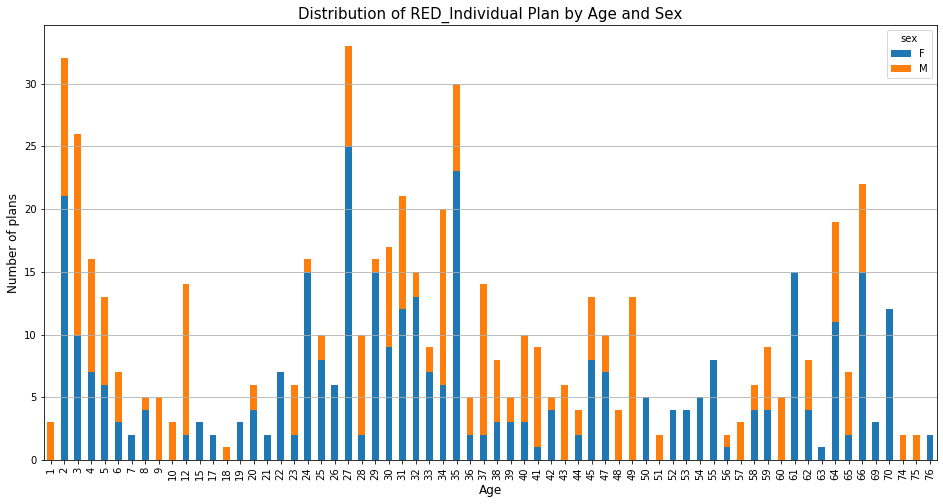

In [11]:
#Visual display of the variation of RED_Individual Plan between groups- Age and Sex

red_plan.plot(kind='bar', stacked=True, figsize=(16,8))
plt.title("Distribution of RED_Individual Plan by Age and Sex", size=15)
plt.xlabel('Age', size=12)
plt.ylabel('Number of plans', size=12)
plt.grid(which='major', axis='y')

#### Q2: Relationship Between Total_Price, Plan and Provider 

In [12]:
# Create a new dataframe with three features, plan, provider_name and total_price
relate_ppp = data[['plan', 'provider_name', 'total_price']].copy()
relate_ppp.head()

,plan,provider_name,total_price
0,RED Individual,JOY HOSPITAL-LAGOS,17000.00
1,Yellow Individual,CHARMAINE HOSPITAL,20000.00
2,Yellow Individual,CHARMAINE HOSPITAL,15000.00
3,Yellow Individual,CILANTRO HOSPITAL,2160.00
4,RED Individual,JOY HOSPITAL-LAGOS,10399.99


In [13]:
print('There are {} different unique Service Providers in our dataset \n'.format(relate_ppp.provider_name.value_counts().count()))
print('There are {} different unique Plans that we offer'.format(relate_ppp.plan.value_counts().count()))

There are 302 different unique Service Providers in our dataset 

There are 58 different unique Plans that we offer


To find the relationship between these features plan, provider and total price, we will transform the categorical features into numerical values

In [14]:
# First, convert to categorical dtype and export to list
plan_label = relate_ppp['plan'].astype('category').cat.categories.tolist()
provider_label =  relate_ppp['provider_name'].astype('category').cat.categories.tolist()

In [17]:
# Create a dictionary as the replacement parameter
plan_repl = {'plan':{k:v for k,v in zip(plan_label, list(range(1, len(plan_label)+1 )))}}
provider_repl = {'provider_name':{k:v for k,v in zip(provider_label, list(range(1, len(provider_label)+1 )))}}

In [18]:
#I will be making use of the "Replace" method to achieve my objective
relate_ppp_new = relate_ppp.copy()

In [19]:
relate_ppp_new.replace(plan_repl, inplace=True)
relate_ppp_new.replace(provider_repl, inplace=True)

print(relate_ppp_new.head())

   plan  provider_name  total_price
0    43            131     17000.00
1    57             47     20000.00
2    57             47     15000.00
3    57             50      2160.00
4    43            131     10399.99


In [20]:
#Evaluate Pearson's correlation between Features of Plan, Provider and Total Price
relate_ppp_new.corr()

,plan,provider_name,total_price
plan,1.000000,-0.106094,-0.097464
provider_name,-0.106094,1.000000,0.028224
total_price,-0.097464,0.028224,1.000000


There is a low positive correlation between Total Price and Provider, 0.028224
while
There is a low negative correlation between Total Price and Plan,  -0.097464

In [21]:
# Now, let's test for the significance of these correlations using p-value from stats

pearson_coef, pval = stats.pearsonr(relate_ppp_new['plan'], relate_ppp_new['total_price'])
print("The Pearson Correlation Coefficient between Plan and Total Price is", pearson_coef, 
      " with a P-value of P =", pval) 

The Pearson Correlation Coefficient between Plan and Total Price is -0.09746433061161174  with a P-value of P = 4.96779947662878e-12


In [22]:
pearson_coef, pval = stats.pearsonr(relate_ppp_new['provider_name'], relate_ppp_new['total_price'])
print("The Pearson Correlation Coefficient between Provider and Total Price is", pearson_coef, 
      " with a P-value of P =", pval) 

The Pearson Correlation Coefficient between Provider and Total Price is 0.02822426872088471  with a P-value of P = 0.045971409726753225


In [23]:
pearson_coef, pval = stats.pearsonr(relate_ppp_new['provider_name'], relate_ppp_new['plan'])
print("The Pearson Correlation Coefficient between Provider and Plan is", pearson_coef, 
      " with a P-value of P =", pval) 

The Pearson Correlation Coefficient between Provider and Plan is -0.10609435087064517  with a P-value of P = 5.4208037815818255e-14


From the above
<ul>
    <li>p-value for Plan-Total_price is $<$ 0.001, ie 4.96779947662878e-12: there is strong evidence that the correlation is significant.</li>
</ul>

<ul>
    <li>p-value for Provider-Total_price is $<$ 0.05, ie 0.045971409726753225: there is moderate evidence that the correlation is significant.</li>
</ul>

<ul>
    <li>p-value for Plan-Provider is $<$ 0.001, ie 5.4208037815818255e-14: there is strong evidence that the correlation is significant.</li>
</ul>

<b/>Visual representation of relationships between Plan, Provider and Total Price

Text(0, 0.5, 'Total price')

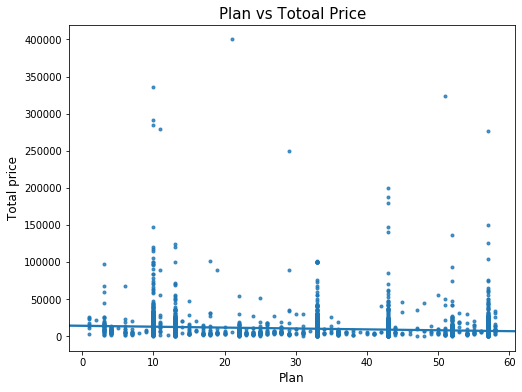

In [24]:
plt.figure(figsize=(8,6))
sns.regplot(x='plan', y='total_price', data=relate_ppp_new, marker='.')
plt.title('Plan vs Totoal Price', size=15)
plt.xlabel('Plan', size=12)
plt.ylabel('Total price', size=12)

Text(0, 0.5, 'Total price')

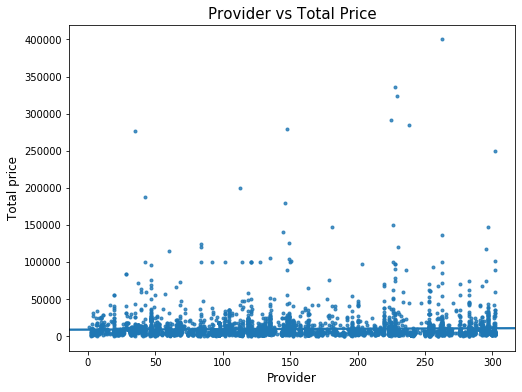

In [25]:
plt.figure(figsize=(8,6))
sns.regplot(x='provider_name', y='total_price', data=relate_ppp_new, marker='.')
plt.title('Provider vs Total Price', size=15)
plt.xlabel('Provider', size=12)
plt.ylabel('Total price', size=12)

In [26]:
#Top performing plans
top_ten_plans = relate_ppp.groupby(by='plan')['total_price'].sum().sort_values()[-10:]

top_ten_plans

plan
Yellow FAMILY OF 4                    496214.10
GREEN Family (1 spouse, 1 child)      601401.50
BLUE Individual                       663896.71
MALTA RED PLAN (Family)               809810.34
Yellow Family                        1701635.67
GREEN Individual                     3403354.92
Yellow Individual                    6644136.89
GREEN Family                         8369846.52
RED Individual                       9495551.61
RED Family                          11240310.07
Name: total_price, dtype: float64

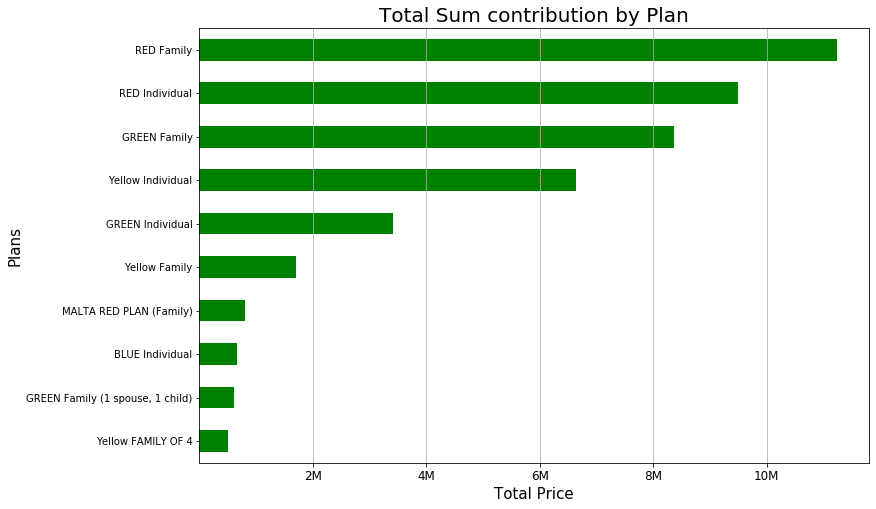

In [27]:
plt.figure(figsize=(12,8))
top_ten_plans.plot(kind='barh', color='green')
plt.title('Total Sum contribution by Plan', size=20)
plt.xticks(ticks=[0.2e7,0.4e7,0.6e7,0.8e7,1e7], labels=['2M', '4M', '6M', '8M', '10M'], size=12)
plt.ylabel('Plans', size=15)
plt.xlabel('Total Price', size=15)
plt.grid(axis='x', which='major')

In [28]:
# Top providers by sum total price
top_ten_providers_price = relate_ppp.groupby(by='provider_name')['total_price'].sum().sort_values()[-10:]

top_ten_providers_price

provider_name
KEZIAH HOSPITAL                     908698.85
LEILA CHILDREN HOSPITAL             987270.00
URSULA HOSPITAL LIMITED             996455.50
WELLNESS CLINICS                   1123538.00
LEILA CHILDREN HOSPITAL - LEKKI    1125497.50
IGWE HOSPITAL NIG. LTD             1135886.25
SPARKLE SPECIALIST HOSPITAL        1313285.77
RIBENA  HOSPITAL                   1319355.20
STAGE HEALTH                       1403366.12
CHARMAINE HOSPITAL                 1471730.00
Name: total_price, dtype: float64

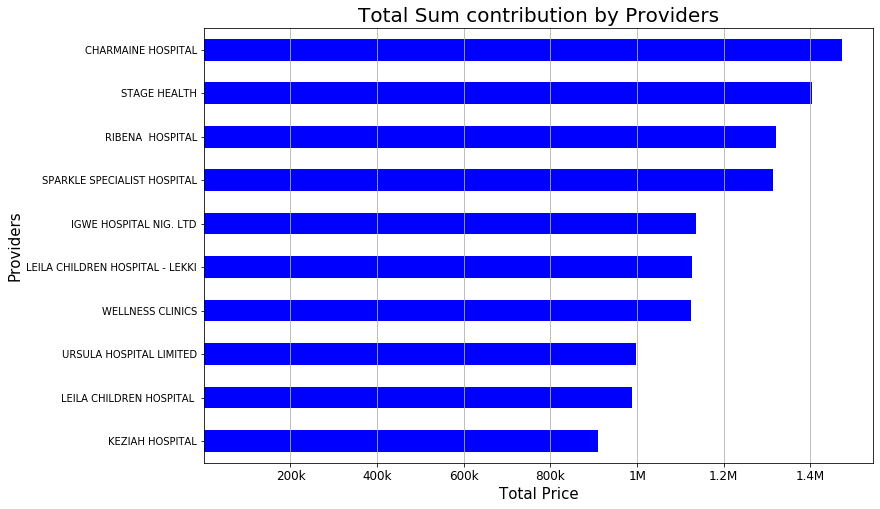

In [29]:
plt.figure(figsize=(12,8))
top_ten_providers_price.plot(kind='barh', color='blue')
plt.title('Total Sum contribution by Providers', size=20)
plt.xticks(ticks=[0.2e6,0.4e6,0.6e6,0.8e6,1e6,1.2e6,1.4e6], labels=['200k', '400k', '600k', '800k', '1M','1.2M','1.4M'], size=12)
plt.ylabel('Providers', size=15)
plt.xlabel('Total Price', size=15)
plt.grid(axis='x', which='major')

In [30]:
# Top most popular providers
top_ten_providers = relate_ppp['provider_name'].value_counts().sort_values()[-10:]

top_ten_providers

MORTAL HOSPITAL                    94
LILAC  HOSPITAL                    95
SEYCHELLES GYM                    105
SPIRIT HOSPITAL                   105
JOEY HOSPITAL                     107
LOYOLA SPECIALIST HOSPITAL        111
ORCHID HOSPITALS                  113
RAMORAY HOSPITAL AND MATERNITY    118
SPARKLE SPECIALIST HOSPITAL       151
IGWE HOSPITAL NIG. LTD            175
Name: provider_name, dtype: int64

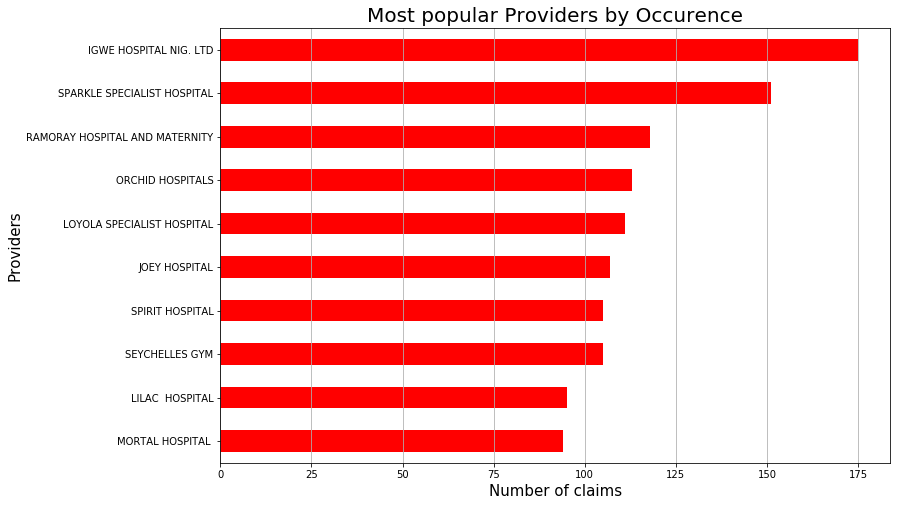

In [31]:
plt.figure(figsize=(12,8))
top_ten_providers.plot(kind='barh', color='red')
plt.title('Most popular Providers by Occurence', size=20)
#plt.xticks(ticks=[0.2e6,0.4e6,0.6e6,0.8e6,1e6,1.2e6,1.4e6], labels=['200k', '400k', '600k', '800k', '1M','1.2M','1.4M'], size=12)
plt.ylabel('Providers', size=15)
plt.xlabel('Number of claims', size=15)
plt.grid(axis='x', which='major')

In [32]:
#Frequency distribution of each plan
print(relate_ppp.plan.value_counts().head())

RED Family           1469
RED Individual       1365
Yellow Individual     580
GREEN Family          412
GREEN Individual      331
Name: plan, dtype: int64


Text(0, 0.5, 'Total Price')

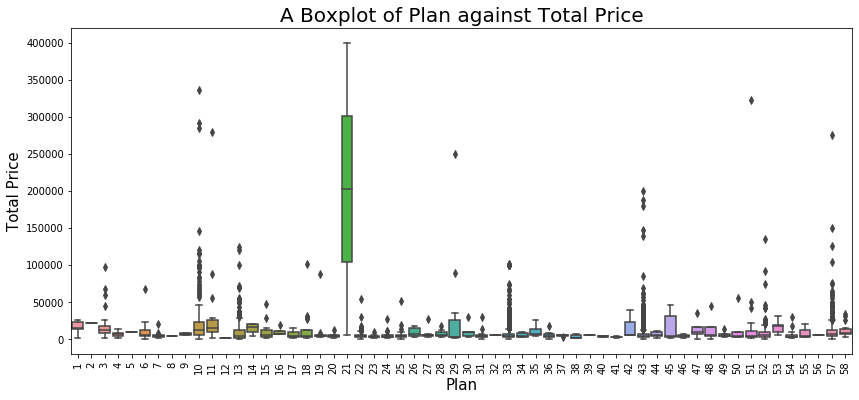

In [33]:
fig, ax1= plt.subplots(figsize=(14,6))
sns.boxplot(x='plan', y='total_price', data=relate_ppp_new, ax=ax1)
plt.title("A Boxplot of Plan against Total Price", size= 20)
plt.xticks(rotation=90)
plt.xlabel('Plan', size=15)
plt.ylabel('Total Price', size=15)

#### Q3. Relationship between Submission Gap and Diagnosis

In [34]:
sub_gap = data.copy()
sub_gap['submission_gap'] = sub_gap['medical_claims_submission_date'] - sub_gap['patient_encounter_date']

sub_gap.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price,submission_gap
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00,21 days
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00,9 days
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00,5 days
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00,15 days
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99,34 days


In [35]:
# convert timedeltas to int
sub_gap['submission_gap'] = (sub_gap.submission_gap/np.timedelta64(1, 'D')).astype(int)
sub_gap.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price,submission_gap
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00,21
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00,9
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00,5
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00,15
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99,34


In [36]:

diagnosis_ = sub_gap.groupby(by='diagnosis')['submission_gap'].mean().sort_values(ascending=False)
diagnosis_[:20]

diagnosis
IMMUNIZATION                                      AUTHORIZATION DODE: PA/D14CCF    389.0
Plasmodiasis/PID                                                                   213.0
Perineal candidiasis with secondary  Bacteria infection/Malaria fever              213.0
SKIN RASH, TINEA CORPORIS                                                          205.0
URTI/FOLLICULITIS                                                                  193.0
Myopia and Presbyopia                                                              170.0
BLOOD TEST                                                                         132.0
acute plasmodiasis\r\nr/o enteric fever                                            123.0
Malaria, uretritis,, htn                                                           120.0
UTI, MALARIA                                                                       120.0
Hyperopic astigmatism, CVS                                                         119.0
HYPERTENSIO

In [37]:
diagnosis_.describe()

count    3622.000000
mean       20.187449
std        21.258578
min        -1.000000
25%         4.000000
50%        15.000000
75%        30.000000
max       389.000000
Name: submission_gap, dtype: float64

Text(0.5, 0, 'Diagnosis')

C:\Users\ChiefCollins\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ChiefCollins\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


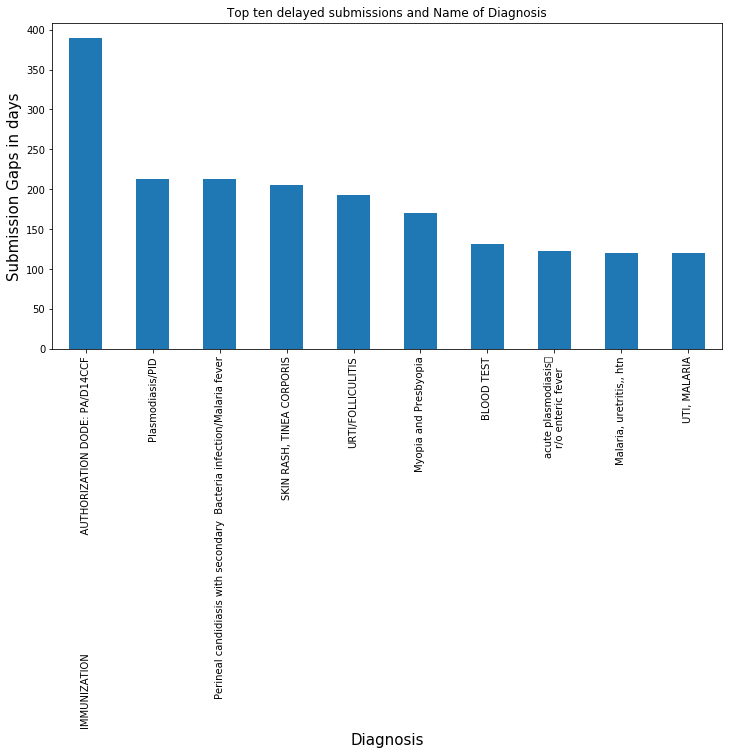

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
diagnosis_[:10].plot(ax=ax, kind='bar')
plt.ylabel('Submission Gaps in days', size=15)
plt.title('Top ten delayed submissions and Name of Diagnosis')
plt.xlabel('Diagnosis', size=15)

#### Q4. Relationship Between Patient Encounter date and Diagnosis

In [39]:
patient_ = data.copy()
patient_dgns = patient_[['patient_encounter_date', 'diagnosis']]
patient_dgns.head()

,patient_encounter_date,diagnosis
0,1997-12-12,ACUTE MALARIA WITH URTI
1,1997-12-24,LEFT MODERATE TO PROFOUND SNHL
2,1997-12-28,LEFT MODERATE TO PROFOUND SNHL
3,1997-12-19,URTI
4,1997-12-01,PLASMODIASIS


In [40]:
patient_dgns['pxt_month'] = patient_dgns.patient_encounter_date.dt.month
patient_dgns['pxt_week'] = patient_dgns.patient_encounter_date.dt.week
patient_dgns['pxt_day'] = patient_dgns.patient_encounter_date.dt.day
patient_dgns['pxt_dayofweek'] = patient_dgns.patient_encounter_date.dt.dayofweek
patient_dgns['pxt_week_day'] = patient_dgns.patient_encounter_date.dt.weekday_name

C:\Users\ChiefCollins\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ChiefCollins\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ChiefCollins\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [41]:
patient_dgns.head()

,patient_encounter_date,diagnosis,pxt_month,pxt_week,pxt_day,pxt_dayofweek,pxt_week_day
0,1997-12-12,ACUTE MALARIA WITH URTI,12,50,12,4,Friday
1,1997-12-24,LEFT MODERATE TO PROFOUND SNHL,12,52,24,2,Wednesday
2,1997-12-28,LEFT MODERATE TO PROFOUND SNHL,12,52,28,6,Sunday
3,1997-12-19,URTI,12,51,19,4,Friday
4,1997-12-01,PLASMODIASIS,12,49,1,0,Monday


In [42]:
# group the diagnosis by month of encounter
patient_dgns_grp = patient_dgns.groupby(by='pxt_month')['diagnosis'].value_counts()
patient_dgns_grp

pxt_month  diagnosis                                                              
1          MALARIA                                                                    25
           URTI                                                                       13
           gym                                                                        13
           Reimbursement Claim                                                         9
           IMMUNIZATION                                                                7
                                                                                      ..
12         urti/skin sepsis                                                            1
           uti, pudx                                                                   1
           vertigo ? cause, low back pain ? cause, malaria fever r/o typhoid fever     1
           vomiting in a neonate ?cause kiv pyloric stenosis,malaria                   1
           xray            

In [43]:
# Actual group by encounter month
patient_dgns_grp_month = patient_dgns_grp.groupby(level=0).sum()
print(patient_dgns_grp_month)

pxt_month
1     778
2     451
3      90
4      99
5     158
6     423
7      87
8      93
9     506
10    834
11    773
12    708
Name: diagnosis, dtype: int64


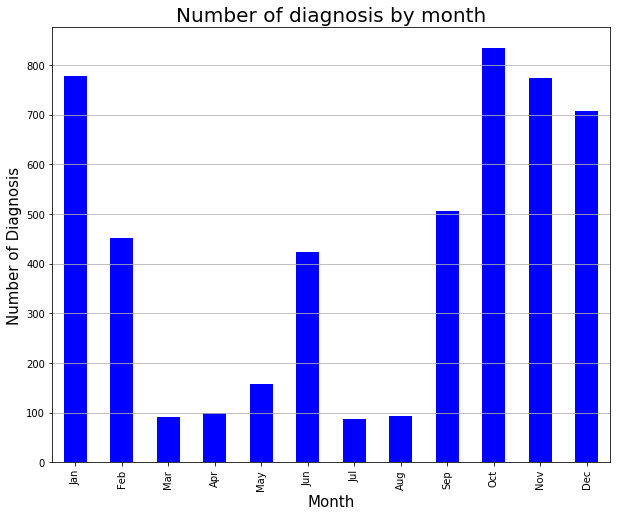

In [45]:
plt.figure(figsize=(10,8))
patient_dgns_grp_month.plot(kind='bar', color='blue')
plt.title('Number of diagnosis by month', size=20)
plt.xlabel('Month', size=15)
plt.ylabel('Number of Diagnosis', size=15)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11], labels=['Jan','Feb','Mar','Apr','May','Jun',
                                                       'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(axis='y', which='major')

From the visual above, we see that the month of October recorded the most Diagnosis. that is, the month patient encountered the service provider

In [46]:
# group the diagnosis by Weekday of encounter
patient_dgns_grp_wkday = patient_dgns.groupby(by='pxt_week_day')['diagnosis'].value_counts()
patient_dgns_grp_wkday

pxt_week_day  diagnosis                            
Friday        MALARIA                                  22
              GYM                                      15
              gym                                      11
              IMMUNIZATION                              7
              PLASMODIASIS                              7
                                                       ..
Wednesday     trauma secondary piercing nail injury     1
              urti ,malaria fever                       1
              urti/musculoskeletal pain                 1
              uti                                       1
              uti,plasmodiasis,sepsis                   1
Name: diagnosis, Length: 4182, dtype: int64

In [47]:
# Actual group by encounter weekday
patient_dgns_grp_wkday = patient_dgns_grp_wkday.groupby(level=0).sum()
print(patient_dgns_grp_wkday)

pxt_week_day
Friday       784
Monday       677
Saturday     797
Sunday       800
Thursday     854
Tuesday      630
Wednesday    458
Name: diagnosis, dtype: int64


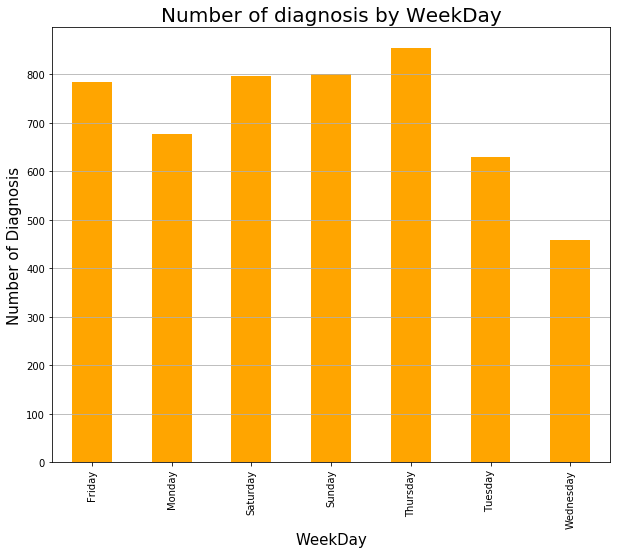

In [48]:
plt.figure(figsize=(10,8))
patient_dgns_grp_wkday.plot(kind='bar', color='orange')
plt.title('Number of diagnosis by WeekDay', size=20)
plt.xlabel('WeekDay', size=15)
plt.ylabel('Number of Diagnosis', size=15)
plt.grid(axis='y', which='major')

From the visual above, we see that most patients had an encounter with the physician mostly on Thursday for a diagnosis. Wednesday had the least number of visits for a diagnosis

#### Q5. Service Type vs Company type analysis

In [49]:
data.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99


In [50]:
service_ = data.groupby(by='service_type')['sex'].value_counts()
service_

service_type  sex
Inpatient     M       184
              F       154
Outpatient    M      2589
              F      2073
Name: sex, dtype: int64

Text(0, 0.5, 'Number of Claims')

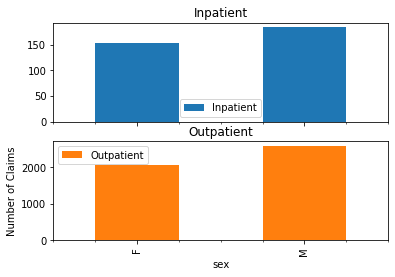

In [51]:
service_.unstack(level=0).plot(kind='bar', subplots=True)
plt.ylabel('Number of Claims')

As we can see from the visualization above, Most of the Outpatient claims are males. Same goes for the Inpatient claims.
The sum of claims from Outpatient is more compared to Inpatient claims from both genders

## Machine Learning 

### Data Preparation

Going into the machine learning model development, it is pertinent tha we first prepare the data features and make them ready for an ML algorithm -Regression

In [52]:
data_ml = data.copy()

In [53]:
data_ml.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99


One-hot encode the Sex and Service type variable

In [54]:
#One-hot encode the Sex and Service type variable
data_ml = pd.get_dummies(data= data_ml, columns=['sex', 'service_type'], prefix=['sex','service'])

data_ml.columns = data_ml.columns.str.strip().str.lower()


In [55]:
data_ml.head()

,age,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,diagnosis,total_price,sex_f,sex_m,service_inpatient,service_outpatient
0,29,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,ACUTE MALARIA WITH URTI,17000.00,0,1,0,1
1,31,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,20000.00,1,0,0,1
2,31,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,15000.00,1,0,1,0
3,23,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,URTI,2160.00,0,1,0,1
4,30,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,PLASMODIASIS,10399.99,1,0,0,1


Transform Plan, Provider and Company columns into numerically coded values 

In [56]:
# Transform Plan, Provider and Company columns into numerically coded values 
mlplan_label = data_ml['plan'].astype('category').cat.categories.tolist()
mlprovider_label =  data_ml['provider_name'].astype('category').cat.categories.tolist()
mlcompany_label = data_ml['company'].astype('category').cat.categories.tolist()

In [57]:
# Create a dictionary as the replacement parameter
mlplan_repl = {'plan':{k:v for k,v in zip(mlplan_label, list(range(1, len(mlplan_label)+1 )))}}
mlprovider_repl = {'provider_name':{k:v for k,v in zip(mlprovider_label, list(range(1, len(mlprovider_label)+1 )))}}
mlcompany_repl = {'company':{k:v for k,v in zip(mlcompany_label, list(range(1, len(mlcompany_label)+1 )))}}

In [58]:
# Carry out columns value replacement operation

data_ml.replace(mlplan_repl, inplace=True)
data_ml.replace(mlprovider_repl, inplace=True)
data_ml.replace(mlcompany_repl, inplace=True)


In [59]:
data_ml.head()

,age,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,diagnosis,total_price,sex_f,sex_m,service_inpatient,service_outpatient
0,29,43,1,131,1997-12-12,1998-01-02,1998-01-02,ACUTE MALARIA WITH URTI,17000.00,0,1,0,1
1,31,57,1,47,1997-12-24,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,20000.00,1,0,0,1
2,31,57,1,47,1997-12-28,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,15000.00,1,0,1,0
3,23,57,1,50,1997-12-19,1998-01-03,1998-01-09,URTI,2160.00,0,1,0,1
4,30,43,1,131,1997-12-01,1998-01-04,1998-01-09,PLASMODIASIS,10399.99,1,0,0,1


We now go on to extract date features from Patient_encounter, medical_claims_submission and payment dates

In [60]:
# Extracting date features from datetime columns

# patient_encounter_date feature
data_ml['pxt_month'] = data_ml.patient_encounter_date.dt.month
data_ml['pxt_week'] = data_ml.patient_encounter_date.dt.week
data_ml['pxt_day'] = data_ml.patient_encounter_date.dt.day
data_ml['pxt_dayofweek'] = data_ml.patient_encounter_date.dt.dayofweek

# medical_claims_submission_date feature
data_ml['med_subm_month'] = data_ml.medical_claims_submission_date.dt.month
data_ml['med_subm_week'] = data_ml.medical_claims_submission_date.dt.week
data_ml['med_subm_day'] = data_ml.medical_claims_submission_date.dt.day
data_ml['med_subm_dayofweek'] = data_ml.medical_claims_submission_date.dt.month

#payment_date feature
data_ml['payment_month']= data_ml.payment_date.dt.month
data_ml['payment_week']= data_ml.payment_date.dt.week
data_ml['payment_day']= data_ml.payment_date.dt.day
data_ml['payment_dayofweek']= data_ml.payment_date.dt.dayofweek


In [61]:
data_ml.head()

,age,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,diagnosis,total_price,sex_f,...,pxt_day,pxt_dayofweek,med_subm_month,med_subm_week,med_subm_day,med_subm_dayofweek,payment_month,payment_week,payment_day,payment_dayofweek
0,29,43,1,131,1997-12-12,1998-01-02,1998-01-02,ACUTE MALARIA WITH URTI,17000.00,0,...,12,4,1,1,2,1,1,1,2,4
1,31,57,1,47,1997-12-24,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,20000.00,1,...,24,2,1,1,2,1,1,1,2,4
2,31,57,1,47,1997-12-28,1998-01-02,1998-01-02,LEFT MODERATE TO PROFOUND SNHL,15000.00,1,...,28,6,1,1,2,1,1,1,2,4
3,23,57,1,50,1997-12-19,1998-01-03,1998-01-09,URTI,2160.00,0,...,19,4,1,1,3,1,1,2,9,4
4,30,43,1,131,1997-12-01,1998-01-04,1998-01-09,PLASMODIASIS,10399.99,1,...,1,0,1,1,4,1,1,2,9,4


In [62]:
data_ml_final = data_ml.select_dtypes(exclude=['datetime64[ns]', 'object'])

In [63]:
data_ml_final.head()

,age,plan,company,provider_name,total_price,sex_f,sex_m,service_inpatient,service_outpatient,pxt_month,...,pxt_day,pxt_dayofweek,med_subm_month,med_subm_week,med_subm_day,med_subm_dayofweek,payment_month,payment_week,payment_day,payment_dayofweek
0,29,43,1,131,17000.00,0,1,0,1,12,...,12,4,1,1,2,1,1,1,2,4
1,31,57,1,47,20000.00,1,0,0,1,12,...,24,2,1,1,2,1,1,1,2,4
2,31,57,1,47,15000.00,1,0,1,0,12,...,28,6,1,1,2,1,1,1,2,4
3,23,57,1,50,2160.00,0,1,0,1,12,...,19,4,1,1,3,1,1,2,9,4
4,30,43,1,131,10399.99,1,0,0,1,12,...,1,0,1,1,4,1,1,2,9,4


In [64]:
# rearranging the dataframe columns, such that we have the predicted column at the end

data_ml_final = data_ml_final[[col for col in data_ml_final.columns if col!= 'total_price'] + ['total_price']]

In [65]:
data_ml_final.head()

,age,plan,company,provider_name,sex_f,sex_m,service_inpatient,service_outpatient,pxt_month,pxt_week,...,pxt_dayofweek,med_subm_month,med_subm_week,med_subm_day,med_subm_dayofweek,payment_month,payment_week,payment_day,payment_dayofweek,total_price
0,29,43,1,131,0,1,0,1,12,50,...,4,1,1,2,1,1,1,2,4,17000.00
1,31,57,1,47,1,0,0,1,12,52,...,2,1,1,2,1,1,1,2,4,20000.00
2,31,57,1,47,1,0,1,0,12,52,...,6,1,1,2,1,1,1,2,4,15000.00
3,23,57,1,50,0,1,0,1,12,51,...,4,1,1,3,1,1,2,9,4,2160.00
4,30,43,1,131,1,0,0,1,12,49,...,0,1,1,4,1,1,2,9,4,10399.99


### Data Standardization

Before going ahead to group into clusters, we first standardize the dataset to avoid bias, especially when the intended algorithm does not have a built-in function to accommodate this tendency.

In [66]:
x_sca = data_ml_final.values

scale = StandardScaler()
standard = scale.fit_transform(x_sca)

standard.mean(axis=0).round(2)    #check that the means are equal to zero(0)

array([ 0., -0., -0.,  0., -0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,
       -0., -0.,  0.,  0., -0.,  0.,  0., -0.])

In [67]:
standard.std(axis=0).round(2)     #check that the standard deviations are equal to one(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [69]:
# Store the scaled dataset in a dataframe

standard_df = pd.DataFrame(data= standard, columns= data_ml_final.columns)

standard_df

,age,plan,company,provider_name,sex_f,sex_m,service_inpatient,service_outpatient,pxt_month,pxt_week,...,pxt_dayofweek,med_subm_month,med_subm_week,med_subm_day,med_subm_dayofweek,payment_month,payment_week,payment_day,payment_dayofweek,total_price
0,-0.096448,0.551068,-0.837749,-0.277585,-0.896159,0.896159,-0.269260,0.269260,1.142471,1.070673,...,0.39679,-1.348576,-1.467748,-1.475514,-1.348576,-1.299600,-1.420138,-1.593895,0.140508,0.413317
1,0.035636,1.514980,-0.837749,-1.279404,1.115873,-1.115873,-0.269260,0.269260,1.142471,1.183262,...,-0.60243,-1.348576,-1.467748,-1.475514,-1.348576,-1.299600,-1.420138,-1.593895,0.140508,0.580620
2,0.035636,1.514980,-0.837749,-1.279404,1.115873,-1.115873,3.713879,-3.713879,1.142471,1.183262,...,1.39601,-1.348576,-1.467748,-1.475514,-1.348576,-1.299600,-1.420138,-1.593895,0.140508,0.301782
3,-0.492701,1.514980,-0.837749,-1.243625,-0.896159,0.896159,-0.269260,0.269260,1.142471,1.126968,...,0.39679,-1.348576,-1.467748,-1.363405,-1.348576,-1.299600,-1.367794,-0.767566,0.140508,-0.414273
4,-0.030406,0.551068,-0.837749,-0.277585,1.115873,-1.115873,-0.269260,0.269260,1.142471,1.014378,...,-1.60165,-1.348576,-1.467748,-1.251296,-1.348576,-1.299600,-1.367794,-0.767566,0.140508,0.045251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.879585,1.170726,-0.837749,-0.206026,1.115873,-1.115873,-0.269260,0.269260,-1.332553,-1.293713,...,-1.60165,-1.115983,-1.098336,1.327216,-1.115983,-1.068765,-1.053727,1.357281,0.620712,-0.408697
4996,-1.879585,1.170726,-0.837749,-0.206026,1.115873,-1.115873,-0.269260,0.269260,-1.332553,-1.462598,...,-0.10282,-1.115983,-1.098336,1.327216,-1.115983,-1.068765,-1.053727,1.357281,0.620712,-0.340660
4997,0.431889,0.551068,1.684072,-0.289511,-0.896159,0.896159,-0.269260,0.269260,-1.332553,-1.293713,...,-0.10282,-1.115983,-1.098336,1.327216,-1.115983,-1.068765,-1.053727,1.357281,0.620712,-0.308436
4998,-0.096448,-0.137440,0.423161,0.342589,1.115873,-1.115873,-0.269260,0.269260,-1.332553,-1.293713,...,-0.10282,-1.115983,-1.098336,1.327216,-1.115983,-1.068765,-1.053727,1.357281,0.620712,-0.317596


### Clustering Groups Using K-Means Algorithm

In [70]:
#Declare a Kmeans object with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

#fit the model to the dataset and predict clusters
clusters = kmeans.fit_predict(standard)

clusters

array([1, 1, 0, ..., 1, 1, 1])

We make use of the ELBOW METHOD check to see if using 3 clusters is optimal for the dataset we have at hand

In [71]:
# Initialise empty elbow 
elbow = {}

# Fit kmeans and calculate elbow for each cluster
for x in range(1, 26):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=x, random_state=42)
    
    # Fit KMeans on the standardized dataset
    kmeans.fit(standard)
    
    # Assign sum of squared distances to k element of dictionary
    elbow[x] = kmeans.inertia_

Text(0, 0.5, 'Elbow')

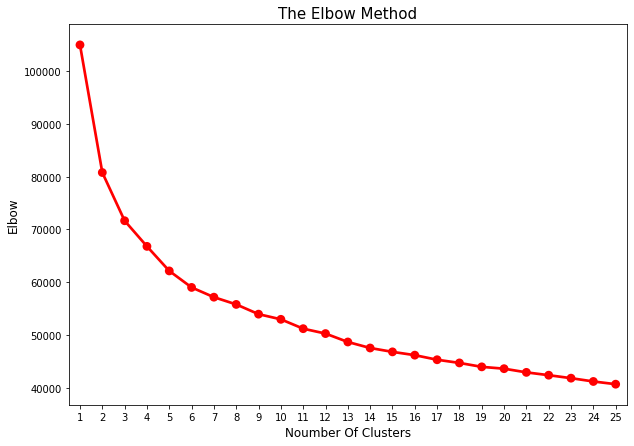

In [73]:
# Plot elbow for each cluster point
plt.figure(figsize=(10,7))
sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()), color='red')
plt.title('The Elbow Method', size=15)
plt.xlabel('Noumber Of Clusters', size=12)
plt.ylabel('Elbow', size=12)

We see from the elbow method that three clusters is sufficient to decribe the dataset. Beyond the third clusters, there is an intengible value added to clustering

In [74]:
clusters.shape

(5000,)

In [75]:
# connect the clusters with the original dataframe 

data_cluster = data.copy()

data_cluster['clusters'] = clusters

data_cluster.head()

,age,sex,plan,company,provider_name,patient_encounter_date,medical_claims_submission_date,payment_date,service_type,diagnosis,total_price,clusters
0,29,M,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-12,1998-01-02,1998-01-02,Outpatient,ACUTE MALARIA WITH URTI,17000.00,1
1,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-24,1998-01-02,1998-01-02,Outpatient,LEFT MODERATE TO PROFOUND SNHL,20000.00,1
2,31,F,Yellow Individual,CORPORATE,CHARMAINE HOSPITAL,1997-12-28,1998-01-02,1998-01-02,Inpatient,LEFT MODERATE TO PROFOUND SNHL,15000.00,0
3,23,M,Yellow Individual,CORPORATE,CILANTRO HOSPITAL,1997-12-19,1998-01-03,1998-01-09,Outpatient,URTI,2160.00,1
4,30,F,RED Individual,CORPORATE,JOY HOSPITAL-LAGOS,1997-12-01,1998-01-04,1998-01-09,Outpatient,PLASMODIASIS,10399.99,1


Text(0, 0.5, 'Twenty-first Feature')

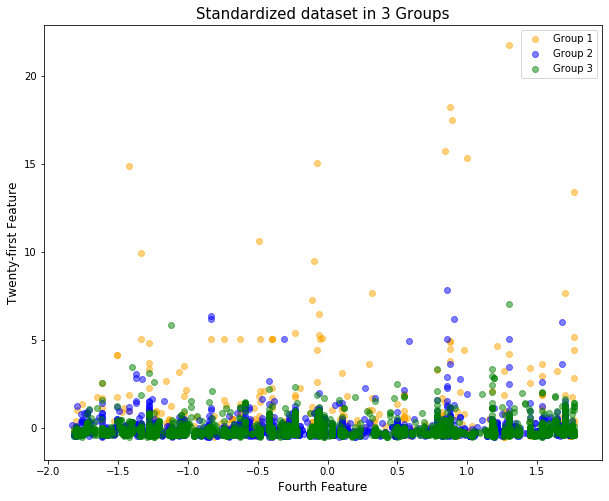

In [90]:
plt.figure(figsize = (10,8))

plt.scatter(standard[clusters == 0, 3], standard[clusters == 0, 20], alpha=.5, 
            color = 'orange', label='Group 1')

plt.scatter(standard[clusters == 1, 3], standard[clusters == 1, 20], alpha=.5, 
            color = 'blue', label='Group 2')

plt.scatter(standard[clusters == 2, 3], standard[clusters == 2, 20], alpha=.5, 
            color = 'green', label='Group 3')

plt.title('Standardized dataset in 3 Groups', size=15)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('Fourth Feature',size=12)
plt.ylabel('Twenty-first Feature', size=12)

#### Cluster group description/analysis

In [91]:
groups = data_cluster.groupby('clusters')

Text(0.5, 1.0, 'Average Age of Group')

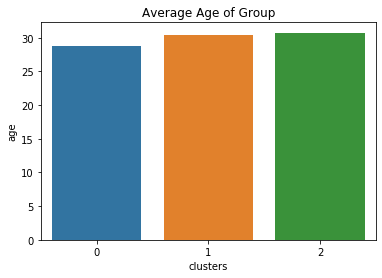

In [92]:
groups_age = groups['age'].mean().reset_index()

sns.barplot(x='clusters', y='age', data=groups_age)
plt.title('Average Age of Group')

Text(0.5, 1.0, 'Average Total Price of Each Group')

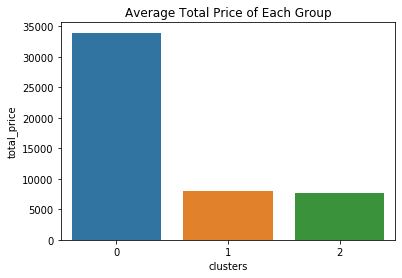

In [93]:
groups_totalprice = groups['total_price'].mean().reset_index()

sns.barplot(x='clusters', y='total_price', data=groups_totalprice)
plt.title('Average Total Price of Each Group')

In [94]:
# Most popular Health Insurance Plan among each group
groups_plan = groups['plan'].agg(pd.Series.mode)

groups_plan

clusters
0    RED Family
1    RED Family
2    RED Family
Name: plan, dtype: object

In [95]:
# Most popular Service type among each group
groups_servicetype = groups['service_type'].agg(pd.Series.mode)

groups_servicetype

clusters
0     Inpatient
1    Outpatient
2    Outpatient
Name: service_type, dtype: object

In [96]:
# Most popular Insurance type (coperate, partnership or individual) among each group
groups_company = groups['company'].agg(pd.Series.mode)

groups_company

clusters
0    CORPORATE
1    CORPORATE
2    CORPORATE
Name: company, dtype: object

In [97]:
# Most popular Provider among each group
groups_provider = groups['provider_name'].agg(pd.Series.mode)

groups_provider

clusters
0                     GLORY SPA
1    LOYOLA SPECIALIST HOSPITAL
2        IGWE HOSPITAL NIG. LTD
Name: provider_name, dtype: object

### Building Predictive Regression model

For this exercise, we will be working with at least two regression algorithms, LinearRegression and Support Vector Regressor, from the Scikit-learn library of Python. We then select the better of the two models

In [98]:
data_ml_final.head()

,age,plan,company,provider_name,sex_f,sex_m,service_inpatient,service_outpatient,pxt_month,pxt_week,...,pxt_dayofweek,med_subm_month,med_subm_week,med_subm_day,med_subm_dayofweek,payment_month,payment_week,payment_day,payment_dayofweek,total_price
0,29,43,1,131,0,1,0,1,12,50,...,4,1,1,2,1,1,1,2,4,17000.00
1,31,57,1,47,1,0,0,1,12,52,...,2,1,1,2,1,1,1,2,4,20000.00
2,31,57,1,47,1,0,1,0,12,52,...,6,1,1,2,1,1,1,2,4,15000.00
3,23,57,1,50,0,1,0,1,12,51,...,4,1,1,3,1,1,2,9,4,2160.00
4,30,43,1,131,1,0,0,1,12,49,...,0,1,1,4,1,1,2,9,4,10399.99


In [99]:
cols = list(data_ml_final.columns)

In [100]:
cols.remove('total_price')

In [101]:
# define the data features
X = data_ml_final[cols].values
Y = data_ml_final['total_price'].values

In [107]:
# using the t_t_split module to split the dataset into training and testing datasets
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=40)

In [108]:
y_test[:10]

array([2140.  , 6069.5 , 4834.95, 3068.9 , 5062.4 , 7200.  , 4548.37,
       3556.2 , 2977.78, 5627.  ])

We will normalize the data, perform a transform and fit the model simultaneously using Pipeline from the sklearn library

LINEAR REGRESSION MODEL

In [109]:
# create pipeline feed
feed =[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=True)), ('model',LinearRegression( fit_intercept=False))]

In [110]:
# Create pipeline object
pipe = Pipeline(feed)
pipe

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [111]:
# fit the model to the dataset
pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [112]:
# Use model to predict Total Price
total_price_pred = pipe.predict(x_test)

In [113]:
print("The MSE is: ", mean_squared_error(y_test, total_price_pred))
print("The MAE is: ", mean_absolute_error(y_test, total_price_pred))

The MSE is:  402305208.2364705
The MAE is:  7187.871027499999


In [114]:
rmse = sqrt(mean_squared_error(y_test, total_price_pred))

print(rmse)

20057.54741329235


In [115]:
mlr_df= pd.DataFrame({"Actual Price":y_test, "Predicted Price":np.round(total_price_pred)})
mlr_df.head(20)

,Actual Price,Predicted Price
0,2140.00,8995.0
1,6069.50,7372.0
2,4834.95,-154.0
3,3068.90,8499.0
4,5062.40,5458.0
5,7200.00,3316.0
6,4548.37,7658.0
7,3556.20,4633.0
8,2977.78,10134.0
9,5627.00,10749.0


Text(0.5, 0, 'Price')

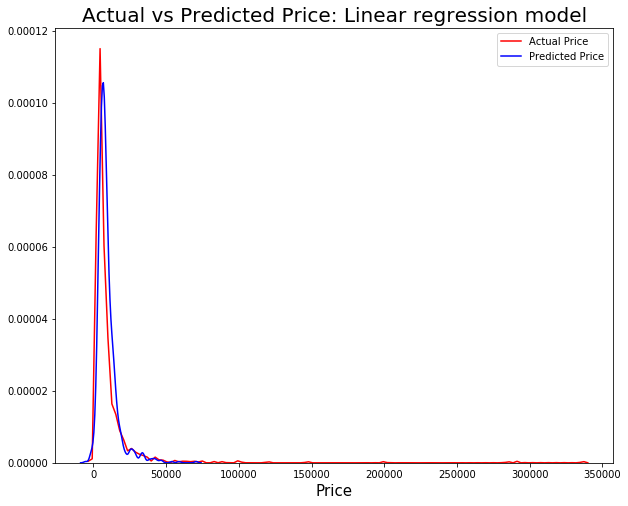

In [128]:
plt.figure(figsize=(10,8))
ax=sns.distplot(mlr_df['Actual Price'], hist=False, color='red', label='Actual Price') 
sns.distplot(mlr_df['Predicted Price'], hist=False, color='blue', label='Predicted Price', ax=ax)
plt.title('Actual vs Predicted Price: Linear regression model', size=20)
plt.xlabel('Price', size=15)

SUPPORT VECTOR REGRESSION MODEL

In [116]:
# create pipeline feed_svr
feed_svr = [('scale', StandardScaler), ('svr_model', SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=5, C=0.1)) ]

In [117]:
# Create pipe instance for svr
pipe_svr = Pipeline(feed_svr)
pipe_svr

Pipeline(memory=None,
         steps=[('scale', <class 'sklearn.preprocessing.data.StandardScaler'>),
                ('svr_model',
                 SVR(C=0.1, cache_size=200, coef0=0.0, degree=5, epsilon=1,
                     gamma=0.01, kernel='poly', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [118]:
#fitting the model to the dataset
X_train_std = StandardScaler().fit_transform(X_train)
x_test_std = StandardScaler().fit_transform(x_test)

In [119]:
# The Support Vector Regression model

svm_model = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=5, C=0.1)
svm_model.fit(X_train_std, Y_train)

total_price_pred_svr = svm_model.predict(x_test)

In [120]:
print("The MSE is: ", mean_squared_error(y_test, total_price_pred_svr))
print("The MAE is: ", mean_absolute_error(y_test, total_price_pred_svr))


The MSE is:  1409967398.8684797
The MAE is:  21142.064062195575


In [121]:
rmse_svr = sqrt(mean_squared_error(y_test, total_price_pred_svr))

print(rmse_svr)

37549.532605193366


In [122]:
svr_df= pd.DataFrame({"Actual Price":y_test, "Predicted Price":np.round(total_price_pred_svr)})
svr_df.head(20)

,Actual Price,Predicted Price
0,2140.00,-7709.0
1,6069.50,3596.0
2,4834.95,-8137.0
3,3068.90,-1270.0
4,5062.40,-3245.0
5,7200.00,5152.0
6,4548.37,5268.0
7,3556.20,-7824.0
8,2977.78,4008.0
9,5627.00,-20101.0


Text(0.5, 0, 'Price')

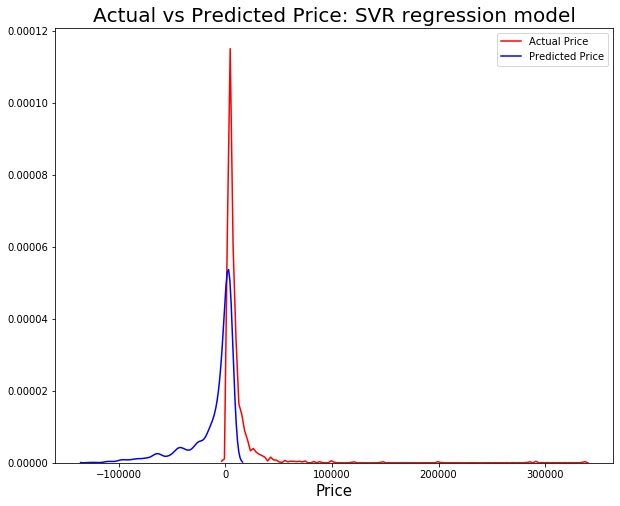

In [129]:
plt.figure(figsize=(10,8))
ax2=sns.distplot(svr_df['Actual Price'], hist=False, color='red', label='Actual Price') 
sns.distplot(svr_df['Predicted Price'], hist=False, color='blue', label='Predicted Price', ax=ax2)
plt.title('Actual vs Predicted Price: SVR regression model', size=20)
plt.xlabel('Price', size=15)

SUPPORT VECTOR LINEAR REGRESSION MODEL

In [123]:
svm_model2 = LinearSVR(epsilon=1,  C=1.1, intercept_scaling= 2.5)  
svm_model2.fit(X_train_std, Y_train)

total_price_pred_svr2 = svm_model2.predict(x_test)

In [124]:
print("The MSE is: ", mean_squared_error(y_test, total_price_pred_svr2))
print("The MAE is: ", mean_absolute_error(y_test, total_price_pred_svr2))

The MSE is:  896875838.7696615
The MAE is:  20063.790594171776


In [125]:
rmse_svr2 = sqrt(mean_squared_error(y_test, total_price_pred_svr2))

print(rmse_svr2)

29947.885380601776


In [126]:
svlr_df= pd.DataFrame({"Actual Price":y_test, "Predicted Price":np.round(total_price_pred_svr2)})
svlr_df.head(20)

,Actual Price,Predicted Price
0,2140.00,-19218.0
1,6069.50,-27.0
2,4834.95,-18114.0
3,3068.90,-10294.0
4,5062.40,-13107.0
5,7200.00,-2374.0
6,4548.37,1232.0
7,3556.20,-8248.0
8,2977.78,1585.0
9,5627.00,-21092.0


Text(0.5, 0, 'Price')

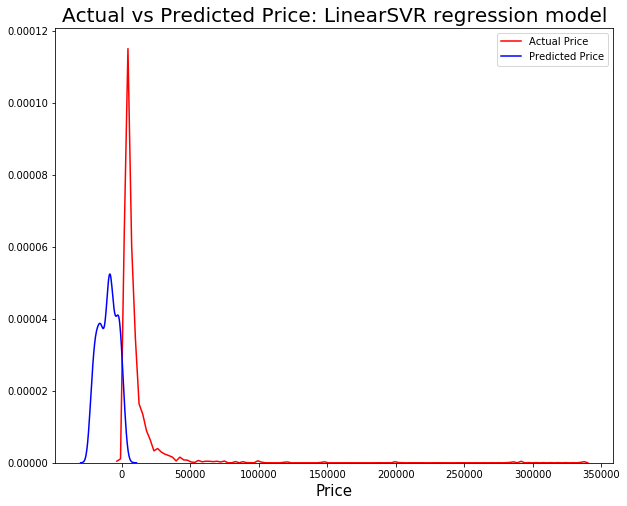

In [130]:
plt.figure(figsize=(10,8))
ax3=sns.distplot(svlr_df['Actual Price'], hist=False, color='red', label='Actual Price') 
sns.distplot(svlr_df['Predicted Price'], hist=False, color='blue', label='Predicted Price', ax=ax3)
plt.title('Actual vs Predicted Price: LinearSVR regression model', size=20)
plt.xlabel('Price', size=15)

Reviewing the three regression models developed, it is evident that the LinearRegression model gave the better prediction of them all. 

Evidently, given more time, we can tune the parameters of this model to give a better prediction model than currenlty is